In [1]:
# %cd gestures/
!ls

Untitled.ipynb				    fit-adv_profiler_logs.txt
Untitled1.ipynb				    fit-prof.txt
__pycache__				    fit-profiler_logs.txt
arcface.py				    gest.zip
asl-sign-detection-pytorch-lightning.ipynb  gestures
autsl-custom-try.ipynb			    mytestfile.hdf5
baseline.ckpt				    pizdec.ipynb
data					    prof_logs
ds.py					    requirements.txt
ds_preprocess.ipynb			    test.npy
effnetb1_226cls_arcface256.ckpt		    untitled.txt
effnetb1_226cls_arcface512.ckpt		    wandb


In [2]:
# pip list

In [3]:
%%time
from tqdm.notebook import tqdm
import torch
from torch import nn, optim
from torch.nn import functional as F
from matplotlib import pyplot as plt
import numpy as np
from torchvision.datasets import ImageFolder
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from torch.utils.data import DataLoader, random_split, Dataset
import pytorch_lightning as pl
from torchvision.models import regnet_y_400mf, RegNet_Y_400MF_Weights, efficientnet_b1, EfficientNet_B1_Weights
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
from arcface import ArcFaceLoss
import graphviz
from torchmetrics.classification import MulticlassAUROC, MulticlassAccuracy, MulticlassConfusionMatrix
from torchvision import transforms as T
import json
import pandas as pd
import os
import seaborn as sns


from pytorch_lightning.callbacks import LearningRateMonitor
torch.set_float32_matmul_precision("medium")

from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam import GradCAM

CPU times: user 4.63 s, sys: 1.08 s, total: 5.72 s
Wall time: 42.7 s


In [4]:
# pip freeze > requirements.txt

In [5]:
# import warnings
# warnings.filterwarnings('ignore')
# warnings.simplefilter('ignore')

In [6]:
# torch.cuda.empty_cache()
print(torch.cuda.list_gpu_processes())

GPU:0
no processes are running


### Dataset

In [7]:
MODEL_RESIZE_SIZE = 550
MODEL_INPUT_SIZE = 500

frame_transform = {
    'train':A.Compose([
        # A.HueSaturationValue(50, 50, 40,p=1.0),
        A.ToFloat(255),
        A.LongestMaxSize(max_size=MODEL_RESIZE_SIZE),
        # A.GaussNoise(var_limit=(0.0, 0.04),p=0.9),
        # # A.GaussianBlur(p=0.6, blur_limit=(3, 5)),
        # A.Normalize(max_pixel_value=1.0),
        # A.PadIfNeeded(MODEL_RESIZE_SIZE,MODEL_RESIZE_SIZE,border_mode=cv2.BORDER_CONSTANT, value=0.0 ), # 
        # A.Affine(scale=[0.95, 1.05], translate_percent=0.05, shear=[-15, 15], p=0.95, mode=cv2.BORDER_CONSTANT), #mode=cv2.BORDER_CONSTANT
        A.RandomCrop(MODEL_INPUT_SIZE, MODEL_INPUT_SIZE),
        ToTensorV2()
    ]),
    'val':A.Compose([
        A.ToFloat(255),
        A.LongestMaxSize(max_size=MODEL_RESIZE_SIZE),
        # A.Normalize(max_pixel_value=1.0),
        # A.PadIfNeeded(MODEL_RESIZE_SIZE,MODEL_RESIZE_SIZE,border_mode=cv2.BORDER_CONSTANT, value=0.0 ), # 
        A.RandomCrop(MODEL_INPUT_SIZE, MODEL_INPUT_SIZE),
        ToTensorV2()
])}



def apply_frame_transform(video, transform_type='train'):
    video = np.array(video, dtype='uint8')
    return frame_transform[transform_type](image=video)['image']


def apply_video_transform(video, transform_type='train'):
    if transform_type == 'test':
        transform_type='val'
    # cnt = int(max([np.round(8 * np.sqrt(len(video) / 25)), 8]))
    cnt = 16
    # print(f'{len(video)=}  -->  {cnt=}')
    video = torch.tensor(video.transpose(0,3,1,2), dtype=torch.uint8)
    # print(f'{video.shape=}')
    res = TV.functional.uniform_temporal_subsample(video, cnt, 0).numpy().transpose(0,2,3,1)
    # print(f'{res.shape=}')
    res = apply_frame_transform(res, transform_type)
    return res.transpose(0,1)

In [8]:
def read_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    
    if len(frames) > 0:
        frames = frames[len(frames) // 2-2:len(frames) // 2+3]
    
    return np.array(frames)

In [9]:
class WLASLDataset(Dataset):
    def __init__(self, dir_path='data/autsl', csv_postfix_file_name="_labels.csv", ds_type='train',):
        self.dir_path = dir_path
        self.ds_type = ds_type
        
        self.df = pd.read_csv(os.path.join(dir_path, ds_type+csv_postfix_file_name), header=None)
        self.df.columns = ['filename', 'cls']        
        self.df = self.df#[self.df['cls'] ]
        self.num_classes = int(self.df['cls'].max() + 1)               
        
    def __len__(self, ):
        # if self.ds_type == 'val':
            # return 300
        return len(self.df)
    
    def __getitem__(self, ind):
        sample = self.df.iloc[ind]
        video_path = os.path.join(self.dir_path, self.ds_type, sample["filename"] + '_color.mp4')
        
        video = read_video(video_path)
        if len(video.shape)!=4:
            print(video_path)
            ind = np.random.randint(len(self))
            return self[ind]
        # video = video
        # video = apply_frame_transform(video, self.ds_type)
        return (video, sample['cls'])

In [10]:
# train_ds = WLASLDataset(ds_type='train')
# val_ds = WLASLDataset(ds_type='val')
# test_ds = WLASLDataset(ds_type='test')

In [11]:
# cnt = 0
# dir_path = 'data/AUTSL_5median_frame'
# os.mkdir(dir_path)
# for ds_name, ds in zip(['train', 'test', 'val'], [train_ds, test_ds, val_ds]):
#     if ds_name != 'test':
#         continue
#     ds_path = os.path.join(dir_path, ds_name)
#     if not os.path.exists(ds_path):
#         os.mkdir(ds_path)
#     for sample in tqdm(ds):
#         for frame in sample[0]:
#             folder_path = os.path.join(ds_path, str(sample[1]))
#             if not os.path.exists(folder_path):
#                 os.mkdir(folder_path)
#             cv2.imwrite(os.path.join(folder_path, f'{cnt}.jpeg'), cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
#             cnt+=1

In [12]:
ds_path = 'data/AUTSL_median_frame'
train_ds = ImageFolder(os.path.join(ds_path, 'train'))
train_ds.transform = lambda x : apply_frame_transform(x, 'train')

val_ds = ImageFolder(os.path.join(ds_path, 'val'))
val_ds.transform = lambda x : apply_frame_transform(x, 'val')

test_ds = ImageFolder(os.path.join(ds_path, 'test'))
test_ds.transform = lambda x : apply_frame_transform(x, 'val')

In [13]:
num_classes = 226
train_ds.samples = [a for a in train_ds.samples if a[1] < num_classes]
test_ds.samples = [a for a in test_ds.samples if a[1] < num_classes]
val_ds.samples = [a for a in val_ds.samples if a[1] < num_classes]


In [14]:
len(train_ds), len(val_ds), len(test_ds)

(28144, 4418, 3742)

In [15]:
vid = train_ds[13][0]
vid

tensor([[[0.7765, 0.7765, 0.7765,  ..., 0.6115, 0.6111, 0.6124],
         [0.7765, 0.7765, 0.7765,  ..., 0.6167, 0.6157, 0.6157],
         [0.7765, 0.7765, 0.7765,  ..., 0.6165, 0.6157, 0.6157],
         ...,
         [0.4166, 0.4166, 0.4166,  ..., 0.3437, 0.3502, 0.3529],
         [0.4275, 0.4275, 0.4275,  ..., 0.3400, 0.3487, 0.3525],
         [0.4311, 0.4311, 0.4277,  ..., 0.3204, 0.3038, 0.2783]],

        [[0.7961, 0.7961, 0.7961,  ..., 0.6547, 0.6542, 0.6556],
         [0.7961, 0.7961, 0.7961,  ..., 0.6599, 0.6588, 0.6588],
         [0.7961, 0.7961, 0.7961,  ..., 0.6596, 0.6588, 0.6588],
         ...,
         [0.3381, 0.3381, 0.3381,  ..., 0.3320, 0.3384, 0.3412],
         [0.3490, 0.3490, 0.3490,  ..., 0.3282, 0.3369, 0.3407],
         [0.3527, 0.3527, 0.3493,  ..., 0.3086, 0.2921, 0.2666]],

        [[0.7725, 0.7725, 0.7725,  ..., 0.5919, 0.5915, 0.5928],
         [0.7725, 0.7725, 0.7725,  ..., 0.5971, 0.5961, 0.5961],
         [0.7725, 0.7725, 0.7725,  ..., 0.5968, 0.5961, 0.

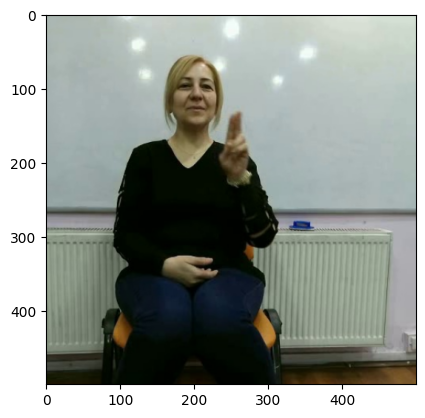

In [16]:
frame = train_ds[50][0]
frame = frame.numpy().transpose(1,2,0)
frame -= frame.min()
frame /= frame.max()
plt.imshow(frame)
plt.show()

In [17]:
def batch_as_list_collate(batch_samples):
    return batch_samples

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=8, drop_last=True ,pin_memory=True)#, collate_fn=batch_as_list_collate)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=8, pin_memory=True)#, collate_fn=batch_as_list_collate)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=8)#, collate_fn=batch_as_list_collate)

### Model

In [18]:
EMB_SIZE = 256
cnn_model_name = 'effnetb1'

In [19]:
class SimilarityToConceptTarget:
    def __init__(self, features):
        self.features = features
    
    def __call__(self, model_output):
        cos = torch.nn.CosineSimilarity(dim=0)
        return cos(model_output, self.features)

In [20]:
class LitCNN(pl.LightningModule):
    def __init__(self, num_classes=num_classes, pretrained_model_file=None):
        super().__init__()
        self.learning_rate = 1e-3
        
        if not pretrained_model_file:
            # self.model = regnet_y_400mf(weights=RegNet_Y_400MF_Weights.IMAGENET1K_V2)
            # self.model.fc = nn.Linear(self.model.fc.in_features, EMB_SIZE)
            self.model = efficientnet_b1(weights=EfficientNet_B1_Weights.IMAGENET1K_V2)
            self.model.classifier = nn.Sequential(
                nn.Dropout(p=0.2, inplace=True),
                nn.Linear(in_features=1280, out_features=EMB_SIZE, bias=True)
            )
        else:
            self.model = torch.load(pretrained_model_file)
            
        # model.model.requires_grad_=False
        
        # self.softmax = nn.Softmax(dim=-1)
        # self.loss_func = nn.CrossEntropyLoss()
        
        self.loss_func = ArcFaceLoss(in_features=EMB_SIZE, num_classes=num_classes,
                                     m=0.5, s=64)
        # self.loss_func = CosFaceLoss(in_features=rnn_emb_size, num_classes=self.num_classes,
        #                              m=0.35, s=64, smoothing_epsilon=0)
        
        self.metric_functions = {'rocauc': MulticlassAUROC(num_classes),
                                 'acc@1' : MulticlassAccuracy(num_classes, top_k=1),
                                 'acc@5' : MulticlassAccuracy(num_classes, top_k=5),
                                 'acc@10': MulticlassAccuracy(num_classes, top_k=10),
                                }
        self.confusion_metric_function = MulticlassConfusionMatrix(num_classes=num_classes, normalize='true').to('cpu')
        self.center_weights = None

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=1e-8)
        # scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=self.learning_rate, 
        #                                           total_steps=self.trainer.estimated_stepping_batches,
        #                                           pct_start=0.1,
        #                                           div_factor=20,
        #                                           final_div_factor=20
        #                                          )
        scheduler = optim.lr_scheduler.StepLR(optimizer, 10000)
        return [optimizer], [{'scheduler': scheduler, 'interval': 'step', 'frequency': 1}]
    

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        emb = self.model(x)
        loss = self.loss_func(emb, y)
        self.log('train_loss', loss)
        
        return {'loss': loss
               }
    
    def training_epoch_end(self, outputs):
        self.log_grad_cam(*test_ds[0])

    def validation_step(self, val_batch, batch_idx):
        if self.center_weights is None:
            self.center_weights = self.loss_func.weight.cpu()
        x, y = val_batch
        emb = self.forward(x)
        loss = self.loss_func(emb, y)
        self.log('val_loss', loss)
        
        emb = F.normalize(emb.cpu())
        dist = torch.cosine_similarity(emb[:, None,...], self.center_weights[None, ...], dim=-1) * self.loss_func.rescale
        
        return {"y_true": y.cpu(),
                "dist": dist}
        
    def log_confusion_matrics(self, y_hat, y_true):
        cm = self.confusion_metric_function.to('cpu')(y_hat, y_true)
        df_cm = pd.DataFrame(cm.numpy(), index=np.arange(cm.shape[0]), columns=np.arange(cm.shape[0]))
        plt.figure(figsize=(45, 40))
        fig_ = sns.heatmap(df_cm, annot=False, cmap='Spectral').get_figure()
        plt.close(fig_)
        self.logger.experiment.add_figure("Confusion matrix", fig_, self.global_step)
    
    def validation_epoch_end(self, outputs):
        self.center_weights = None
        yy_hat, yy_true = [], []
        for out in outputs:
            yy_hat.append(out['dist'])
            yy_true.append(out['y_true'])
        
        yy_hat = torch.vstack(yy_hat)
        yy_true = torch.hstack(yy_true)
        
        for name, metric in self.metric_functions.items():
            res = metric(yy_hat, yy_true)
            self.log(name, res)
            
        # self.log_confusion_matrics(yy_hat.cpu(), yy_true.cpu())
        
    
    def log_grad_cam(self, img_tensor, cls_id):
        concept_features = self.loss_func.weight[cls_id]
        targets = [SimilarityToConceptTarget(concept_features)]

        input_tensor = img_tensor[None, ...]
        image_float = img_tensor.numpy().transpose(1,2,0)
        image_float -= image_float.min()
        image_float /= image_float.max()
        
        for i in range(len(self.model.features)):
            target_layers = [self.model.features[i]]            
            with GradCAM(model=self.model,
                         target_layers=target_layers,
                         use_cuda=True) as cam:
                grayscale_cam = cam(input_tensor=input_tensor,
                                    targets=targets)[0, :]
            
            cam_image = show_cam_on_image(image_float, grayscale_cam, use_rgb=True)
            fig = plt.figure(figsize=(45, 40))
            plt.imshow(cam_image)
            plt.close(fig)
            # self.logger.experiment.add_figure(f"GradCam(layer{i},{cls_id=})", fig, self.global_step)
            self.zero_grad()

        with torch.no_grad():
            self.log('cos dist of test img', targets[0](self.model(input_tensor.cuda())[0]))

# data

# model
# model = LitCNN(pretrained_model_file='effnetb1_226cls_arcface256.ckpt')
model = LitCNN()

In [21]:
import wandb
WANDB_APIKEY = 'a5bd0bef55f8b72f59ac12d24f1623ad19eeb67b'
wandb.login(key=WANDB_APIKEY)
logger = WandbLogger(project='gestures')

wandb: Currently logged in as: eldervald (valoebi). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


### Train 

In [22]:
# logger = TensorBoardLogger("../tf_logs/", name=f"5mf-img_embs-{cnn_model_name}-{EMB_SIZE}-{num_classes}cls+gradcam")
lr_monitor = LearningRateMonitor(logging_interval='step')
from pytorch_lightning.profilers import AdvancedProfiler, SimpleProfiler
profiler = AdvancedProfiler(dirpath='./', filename='adv_profiler_logs')
trainer = pl.Trainer(accelerator='gpu',
                     devices=1, 
                     logger=logger,
                     accumulate_grad_batches=8,
                     # auto_lr_find=True,
                     log_every_n_steps=1,
                     max_epochs=20,
                     val_check_interval=1.0,
                     callbacks=[lr_monitor],
                     profiler=SimpleProfiler(dirpath='./', filename='profiler_logs')
                     # profiler=profiler
                     # track_grad_norm=2,
                     # gradient_clip_val=10,
                     # gradient_clip_algorithm="norm",
                    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


In [23]:
# trainer.tune(model, train_loader, val_loader, lr_find_kwargs={"num_training":200})

In [24]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                      | Type                      | Params
------------------------------------------------------------------------
0 | model                     | EfficientNet              | 6.8 M 
1 | loss_func                 | ArcFaceLoss               | 57.9 K
2 | confusion_metric_function | MulticlassConfusionMatrix | 0     
------------------------------------------------------------------------
6.9 M     Trainable params
0         Non-trainable params
6.9 M     Total params
27.596    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [25]:
# torch.save(model.model, f'{cnn_model_name}_{num_classes}cls_arcface{EMB_SIZE}.ckpt')

In [26]:
model = model.cuda()

In [27]:
loader = iter(train_loader)

In [28]:
%%time
sample = train_ds[0]

CPU times: user 22.7 ms, sys: 16.4 ms, total: 39.1 ms
Wall time: 23.7 ms


In [29]:
%%time
batch = next(loader)

CPU times: user 102 ms, sys: 63.6 ms, total: 166 ms
Wall time: 1.4 s


In [30]:
%%time
X = batch[0].cuda()

CPU times: user 13.2 ms, sys: 3.57 ms, total: 16.8 ms
Wall time: 15.7 ms


In [31]:
%%time
y = model(X)

CPU times: user 58.6 ms, sys: 3.8 ms, total: 62.4 ms
Wall time: 62 ms


In [32]:
model.model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [33]:
from torchmetrics.functional import pairwise_cosine_similarity

In [ ]:
yy_hat, yy_true = [], []
        
model.cpu()
for val_batch in tqdm(test_loader):
    x, y = val_batch
    emb = model.forward(x)
    loss = model.loss_func(emb, y)

    emb = F.normalize(emb.cpu())
    dist = torch.cosine_similarity(emb[:, None,...], 
                                   emb[None,...], dim=-1).detach().numpy()
    # dist = pairwise_cosine_similarity(emb).detach().numpy()
    print(emb)
    sns.heatmap(dist)
    # plt.show()

    yy_hat.append(dist)
    yy_true.append(y)
    
    

yy_hat = torch.vstack(yy_hat)
yy_true = torch.hstack(yy_true)

  0%|          | 0/117 [00:00<?, ?it/s]

In [ ]:
ds = ImageFolder('gestures/')

def get_image_from_ind(ind, ds=ds):
    """A function that gets a URL of an image, 
    and returns a numpy image and a preprocessed
    torch tensor ready to pass to the model """

    img = np.array(ds[ind][0])
    img = cv2.resize(img, (256, 256))
    rgb_img_float = np.float32(img) / 255
    input_tensor = preprocess_image(rgb_img_float,
                                   mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
    return img, rgb_img_float, input_tensor


    
model = torch.load(f'{cnn_model_name}_{num_classes}cls_arcface{EMB_SIZE}.ckpt')
target_layers = [model.features[-9]]

In [ ]:
len(model.features)

In [ ]:
# Where is the car in the image
for target_id in [0,2,4]:
    ttensor = train_ds[target_id][0][None, ...]
    concept_features = model(ttensor)[0, :]
    targets = [SimilarityToConceptTarget(concept_features)]
    for i in [10,20,40]:
        input_tensor = train_ds[i][0][None, ...]
        image_float = train_ds[i][0].numpy().transpose(1,2,0)
        print(image_float.shape)
        image_float -= image_float.min()
        image_float /= image_float.max()
        with GradCAM(model=model,
                     target_layers=target_layers,
                     use_cuda=False) as cam:
            grayscale_cam = cam(input_tensor=input_tensor,
                                targets=targets)[0, :]
        cam_image = show_cam_on_image(image_float, grayscale_cam, use_rgb=True)
        plt.imshow(cam_image)
        plt.show()